In [23]:
import tensorflow as tf
from tensorflow import keras

In [20]:
import numpy
import os 
import cv2
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras import backend as K
import random
import pickle



In [35]:

import os
from pathlib import Path
root = os.getcwd() # Don't change this
data_dirname = '/data_test/plantvillage/' # Change as you like 
p = Path(root + data_dirname)
p.mkdir(exist_ok=True) # should "/content/gdrive/My Drive/data"


In [36]:
classes = ['Apple___Apple_scab','Apple___healthy']
for c in classes:
  print(c)
  filelist = [x for x in (p/c).iterdir() if x.is_file()]
  for f in filelist:
    img = cv2.imread(str(f))
    if img is None:
      print(f'Failed to open {f}. Deleting file')
      os.remove(str(f))

Apple___Apple_scab
Apple___healthy


In [37]:

# Pick first image of first class (i.e., cat)
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = filelist[1]
print(f"File path: {img_path}")

# Load image and preprocess it
img = load_img(img_path, target_size=(120, 120))
img_data = img_to_array(img, dtype = int)
img_data = np.expand_dims(img_data, axis=0)

File path: c:\Users\mwels\Documents\Uni\11. Semester\Deep learning in visual recognition\myawesome\data_test\plantvillage\Apple___Apple_scab\01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG


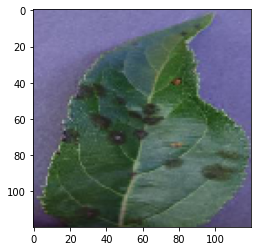

In [41]:
from cgitb import grey

plt.imshow(img_data[0])

In [42]:
img_data[0].shape

(120, 120, 3)

In [43]:
def getPermutation(image_array, tilenumberx=3, shuffle = True):
    """Takes an image as an array, and returns a permuted image as an array
    with corresponding labels.
    """
    idx = range(tilenumberx**2)
    if shuffle:
        idx = np.random.permutation(tilenumberx**2)
    tilesize_h = image_array.shape[0]//(tilenumberx)
    tilesize_w = image_array.shape[1]//(tilenumberx)
    #if len(image_array.shape) == 4:
    #    tiles = [np.array([image[(i//3)*tilesize_h:(i//3+1)*tilesize_h,(i%tilenumberx)*tilesize_w:(i%tilenumberx+1)*tilesize_w,:] for i in idx])for image in image_array]
    #else:
    #    tiles = [image_array[(i//3)*tilesize_h:(i//3+1)*tilesize_h,(i%tilenumberx)*tilesize_w:(i%tilenumberx+1)*tilesize_w,:] for i in idx]
    tiles = [image_array[(i//3)*tilesize_h:(i//3+1)*tilesize_h,(i%tilenumberx)*tilesize_w:(i%tilenumberx+1)*tilesize_w,:] for i in idx]
    out = np.array(tiles)
    

    return out, idx

In [44]:
def showPermImg(X, y):
    plt.figure(figsize=(3,3))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(X[i])
        plt.xticks([]), plt.yticks([])
        plt.title(int(y[i]))

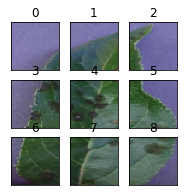

In [45]:
X, y = getPermutation(img_data[0], shuffle=False)
showPermImg(X,y)

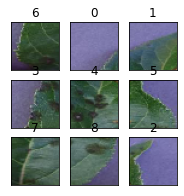

In [46]:
X, y = getPermutation(img_data[0])
showPermImg(X,y)

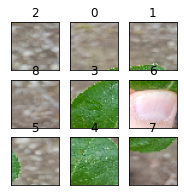

In [47]:
# Load image and preprocess it
img1 = load_img('data_test/Plantdoc/Apple_leaf_test/20180511_091252-1gy5xf5-e1526048000596.jpg', target_size=(120, 120))
img_data1 = img_to_array(img1, dtype = int)
showPermImg(*getPermutation(img_data1))

In [59]:
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
import cv2

class PermNetDataGenerator(Iterator):

    def __init__(self, input, batch_size=64,
                 preprocess_func=None, shuffle=False):
        if type(input) == list:
            self.im_as_files = True
            self.input_shape = (9,40,40,3) #should prob not be harcoded
        else:
            self.input_shape = self.images.shape[1:]
        self.images = input
        self.batch_size = batch_size
        self.preprocess_func = preprocess_func
        self.shuffle = shuffle
        self.n = len(input)

        # add dimension if the images are greyscale
        if len(self.input_shape) == 2:
            self.input_shape = self.input_shape + (1,)
        N = len(self.images)

        super(PermNetDataGenerator, self).__init__(N, batch_size, shuffle, None)
        
    def _get_batches_of_transformed_samples(self, index_array):
        # create array to hold the images
        batch_x = np.zeros((len(index_array),) + self.input_shape, dtype='float32')
        # create array to hold the labels
        batch_y = np.zeros((len(index_array),9), dtype='float32')

        # iterate through the current batch
        for i, j in enumerate(index_array):
            
            if self.im_as_files:
                image = img_to_array(load_img(self.images[j], target_size=(120, 120))) / 255 #should prob not be hardcoded
            else:
                image = self.images[j].squeeze()
            X, y = getPermutation(image)
            # store the image and label in their corresponding batches
            batch_x[i] = X
            batch_y[i] = y

        # preprocess input images
        if self.preprocess_func:
            batch_x = self.preprocess_func(batch_x)

        return batch_x, batch_y

    def next(self):
        with self.lock:
            # get input data index and size of the current batch
            index_array = next(self.index_generator)
        # create array to hold the images
        return self._get_batches_of_transformed_samples(index_array)


(16, 9, 40, 40, 3) (16, 9)


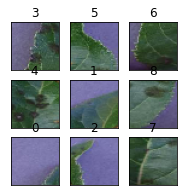

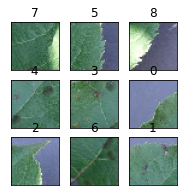

In [49]:
datagenPerm = PermNetDataGenerator(filelist, 16)
X, y = datagenPerm.next()
print(X.shape, y.shape)
showPermImg(X[1],y[1])
showPermImg(X[2],y[2])

In [15]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(120, 120, 3))

2022-10-05 14:10:45.194810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
gen_path = p
train_generator = datagen.flow_from_directory(str(gen_path),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='training')
validation_generator = datagen.flow_from_directory(str(gen_path),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='validation')

Found 2537 images belonging to 4 classes.
Found 634 images belonging to 4 classes.


In [17]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model

# Add new top layer
N = 4
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) #dense layer
preds = Dense(N,activation='softmax')(x) #final layer with softmax activation

# Specify model
model = Model(inputs=conv_base.input, outputs=preds)

In [18]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


In [19]:
from keras import optimizers

# Set up optimizer
sgd_optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='binary_crossentropy',metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 10 epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=5)

/Users/jonaspedersen/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/var/folders/l9/9d49h4t14s52dq6c276zwhgc0000gn/T/ipykernel_56639/2694328886.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/5
317/317 [==============================] - 45s 132ms/step - loss: 0.1887 - accuracy: 0.8715 - val_loss: 0.0902 - val_accuracy: 0.9509
Epoch 2/5
317/317 [==============================] - 41s 131ms/step - loss: 0.0788 - accuracy: 0.9612 - val_loss: 0.0718 - val_accuracy: 0.9462
Epoch 3/5
317/317 [==============================] - 39s 122ms/step - loss: 0.0555 - accuracy: 0.9743 - val_loss: 0.0562 - val_accuracy: 0.9715
Epoch 4/5
317/317 [==============================] - 38s 121ms/step - loss: 0.0425 - accuracy: 0.9838 - val_loss: 0.0491 - val_accuracy: 0.9778
Epoch 5/5
317/317 [==============================] - 37s 117ms/step - loss: 0.0352 - accuracy: 0.9889 - val_loss: 0.0455 - val_accuracy: 0.9747


In [20]:
model.save("models/2022_09_29__01")

INFO:tensorflow:Assets written to: models/2022_09_29__01/assets


INFO:tensorflow:Assets written to: models/2022_09_29__01/assets


In [3]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(40, 40, 3))
type(conv_base)


17225924/17225924 [==============================] - 1s 0us/step


keras.engine.functional.Functional

In [63]:
from keras.layers import Dense,GlobalAveragePooling2D, Concatenate, Input, Flatten
from keras.models import Model


number_of_tiles = 9
image_net = conv_base
tile1 = Input((40,40,3))
tile2 = Input((40,40,3))
tile3 = Input((40,40,3))
tile4 = Input((40,40,3))
tile5 = Input((40,40,3))
tile6 = Input((40,40,3))
tile7 = Input((40,40,3))
tile8 = Input((40,40,3))
tile9 = Input((40,40,3))

embedding_of_tile1 = image_net(tile1) 
embedding_of_tile2 = image_net(tile2)
embedding_of_tile3 = image_net(tile3) 
embedding_of_tile4 = image_net(tile4) 
embedding_of_tile5 = image_net(tile5) 
embedding_of_tile6 = image_net(tile6)
embedding_of_tile7 = image_net(tile7)
embedding_of_tile8 = image_net(tile8)
embedding_of_tile9 = image_net(tile9)

concatonation = Concatenate(axis=1)([
    embedding_of_tile1,
    embedding_of_tile2,
    embedding_of_tile3,
    embedding_of_tile4,
    embedding_of_tile5,
    embedding_of_tile6,
    embedding_of_tile7,
    embedding_of_tile8,
    embedding_of_tile9
    ])
out = Dense(1, activation="tanh")(concatonation)
out = Flatten()(out)

# Specify model
model = Model(inputs=[tile1, tile2, tile3, tile4, tile5, tile6, tile7, tile8, tile9], outputs=out)

In [64]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 input_41 (InputLayer)          [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 input_42 (InputLayer)          [(None, 40, 40, 3)]  0           []                               
                                                                                           

In [33]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 6
Number of pretrained base layers is 86


In [65]:

from isort import file
from keras import optimizers
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(filelist)

train_generator = PermNetDataGenerator(x_train, 16)
validation_generator = PermNetDataGenerator(x_test, 16)


# Set up optimizer
sgd_optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='binary_crossentropy',metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 10 epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=5)

Epoch 1/5


c:\Users\mwels\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\mwels\AppData\Local\Temp\ipykernel_11636\1774256659.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


ValueError: in user code:

    File "c:\Users\mwels\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\mwels\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mwels\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\mwels\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\mwels\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\mwels\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_11" expects 9 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None, None) dtype=float32>]


In [56]:
print(len(x_train))
print(len(x_test))
print(len(filelist))

472
158
630
